In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import pandas as pd

In [32]:
POI_FILENAME = "../data/poi-paris.pkl"
parismap = mpimg.imread('../data/paris-48.806-2.23--48.916-2.48.jpg')
## coordonnees GPS de la carte
xmin, xmax = 2.23, 2.48  # coord_x min et max
ymin, ymax = 48.806, 48.916  # coord_y min et max
coords = [xmin, xmax, ymin, ymax]

In [33]:
class Density(object):
    def fit(self,data):
        pass
    def predict(self,data):
        pass
    def score(self,data):
        #A compléter : retourne la log-vraisemblance: ki/NV
        density = self.predict(data)
        return np.log( np.where(density == 0, 1e-10, density) ).sum()

In [34]:
class Histogramme(Density):
    def __init__(self,steps=10):
        Density.__init__(self)
        self.steps = steps
        self.h=None
    def fit(self,x):
        #A compléter : apprend l'histogramme de la densité sur x
        self.h=np.histogramdd(x,bins=self.steps,density=True)
    def predict(self,x):
        #A compléter : retourne la densité associée à chaque point de x
        def to_bin(x):
            x1_bin=0
            x2_bin=0
            H,edges=self.h
            for i in range(0,len(edges[0])-1):
                if x[0]>edges[0][i] and x[0]<edges[0][i+1]:
                    x1_bin=i
                    break
            for i in range(0,len(edges[1])-1):
                if x[1]>edges[1][i] and x[1]<edges[1][i+1]:
                    x2_bin=i
                    break
            return (x1_bin,x2_bin)
        
        prediction = []
        toBin=np.array([to_bin(x_i) for x_i in x])
        for coords in toBin:
            density_value=self.h[0][coords[0],coords[1]]
            prediction.append(density_value)
        return np.array(prediction)
        

In [35]:
class KernelDensity(Density):
    def __init__(self,kernel=None,sigma=0.1):
        Density.__init__(self)
        self.kernel = kernel
        self.sigma = sigma
    def fit(self,x):
        self.x = x
    def predict(self,data):
        #A compléter : retourne la densité associée à chaque point de data
        n,d=self.x.shape
        predictions=[]
        for x_i in data:
            x_i_0=np.vstack([x_i]*n)
            somme_kernel=self.kernel((x_i_0-self.x)/self.sigma).sum()
            predictions.append(somme_kernel/(n*(self.sigma**d)))

        return np.array(predictions)

In [36]:
def get_density2D(f,data,steps=100):
    """ Calcule la densité en chaque case d'une grille steps x steps dont les bornes sont calculées à partir du min/max de data. Renvoie la grille estimée et la discrétisation sur chaque axe.
    """
    xmin, xmax = data[:,0].min(), data[:,0].max()
    ymin, ymax = data[:,1].min(), data[:,1].max()
    xlin,ylin = np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps)
    xx, yy = np.meshgrid(xlin,ylin)
    grid = np.c_[xx.ravel(), yy.ravel()]
    res = f.predict(grid).reshape(steps, steps)
    return res, xlin, ylin

In [37]:
def show_img(img=parismap):
    """ Affiche une matrice ou une image selon les coordonnées de la carte de Paris.
    """
    origin = "lower" if len(img.shape) == 2 else "upper"
    alpha = 0.3 if len(img.shape) == 2 else 1.
    plt.imshow(img, extent=coords, aspect=1.5, origin=origin, alpha=alpha)
    ## extent pour controler l'echelle du plan

In [38]:
def show_density(f, data, steps=100, log=False):
    """ Dessine la densité f et ses courbes de niveau sur une grille 2D calculée à partir de data, avec un pas de discrétisation de steps. Le paramètre log permet d'afficher la log densité plutôt que la densité brute
    """
    res, xlin, ylin = get_density2D(f, data, steps)
    xx, yy = np.meshgrid(xlin, ylin)
    plt.figure()
    show_img()
    if log:
        res = np.log(res+1e-10)
    plt.scatter(data[:, 0], data[:, 1], alpha=0.8, s=3)
    show_img(res)
    plt.colorbar()
    plt.contour(xx, yy, res, 20)

In [39]:
def load_poi(typepoi,fn=POI_FILENAME):
    """ Dictionaire POI, clé : type de POI, valeur : dictionnaire des POIs de ce type : (id_POI, [coordonnées, note, nom, type, prix])
    
    Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, 
    clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
    """
    poidata = pickle.load(open(fn, "rb"))
    data = np.array([[v[1][0][1],v[1][0][0]] for v in sorted(poidata[typepoi].items())])
    note = np.array([v[1][1] for v in sorted(poidata[typepoi].items())])
    return data,note

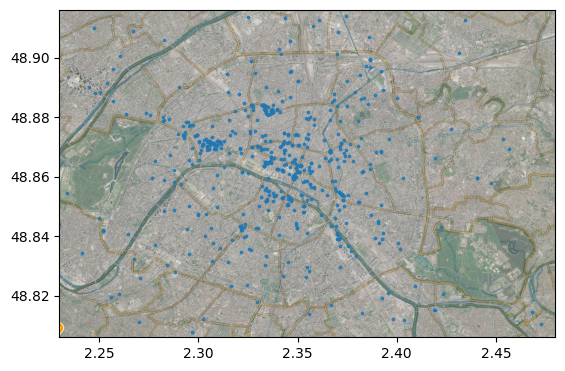

In [40]:
plt.ion()
# Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
# La fonction charge la localisation des POIs dans geo_mat et leur note.
geo_mat, notes = load_poi("night_club")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)

In [41]:
data,classe=load_poi("bar")
#print(data)
x1,x2=data[0]
#print("x1",x1,x2)
#print("data",data)
#print(data==0)
#np.where(data==0,10e-10,data)
#len(data)

In [42]:
for s in range(10,101):
    f=Histogramme(s)
    f.fit(data)
    #print(f.predict(data))
    #show_density(f,data,steps=f.steps,log=True)
    print(f.score(data))
    #print(get_density2D(f,data,s))
"""Plus on augmente le nombre d'intervalle, plus il y a des intervalles vides"""

18906.29563474373
18959.033305870988
19055.669362302226
19123.407450429826
19144.832595121054
19266.886949429678
19294.020297219864
19413.469198456238
19490.70523063024
19507.754573553982
19579.267962075573
19649.42549874993
19739.322147330935
19709.954295108084
19860.25181575862
19920.56864457804
19953.18894036291
20058.641620753362
20120.295621897993
20208.021513446933
20228.06252417397
20285.401268538575
20410.295535274592
20412.067318633908
20539.65111363792
20514.697630204504
20644.468321681547
20654.53497046965
20681.02753702717
20797.399994309897
20796.006120701466
20922.432562852526
20942.828444557217
21101.439647147676
21123.29756122282
21186.253684167543
21223.630912461835
21286.151351636254
21370.930631727388
21426.86960451187
21486.377797895213
21519.430792047944
21662.86480391208
21628.47400697794
21760.597957416274
21802.790268933946
21914.351125062625
21897.760035368923
22040.208012600822
22107.618007620353
22124.715670597252
22170.026000636673
22322.21638137791
22301.17

"Plus on augmente le nombre d'intervalle, plus il y a des intervalles vides"

# Validation Croisé

In [43]:
def test(model,data,debut,fin):
    data_test=data[debut:fin]
    #data_train=data[:debut]+data[fin:]
    data_train=np.concatenate((data[:debut],data[fin:]),axis=0)
    model.fit(data_train)
    score=model.score(data_test)
    return score

def validation_croise(data,steps):
    longeur_data=len(data)
    scores=[]
    model=Histogramme(steps)
    for i in range(10):
        debut=(longeur_data/10)*i
        fin=(longeur_data/10)*(i+1)
        scores.append(test(model,data,int(debut),int(fin)))
    
    return np.mean(scores)

def crois_validation_plot(data):
    x=[i for i in range(1,40)]
    y=[validation_croise(data,i) for i in x]
    #on fait +1 a argmax car x commence à 1
    return x,y,np.argmax(y)+1




Ici on en déduit qu'il y a un sur-apprentissage donc on fera un validation croisé pour trouver le nombre step optimal.

20


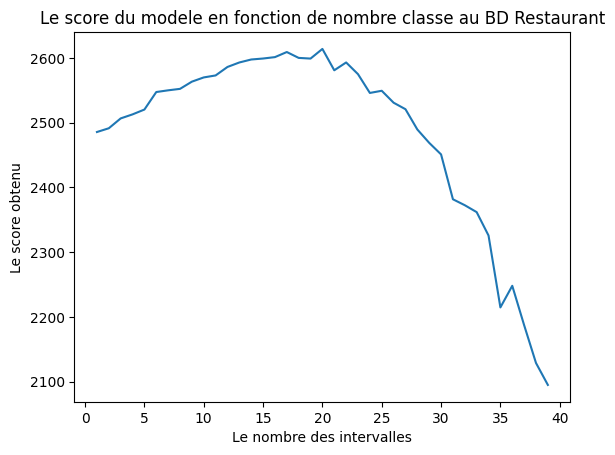

In [44]:
data,classe=load_poi("restaurant")
#print(len(data))
x,y,best_fit=crois_validation_plot(data)
print(best_fit)
plt.xlabel("Le nombre des intervalles")
plt.ylabel("Le score obtenu")
plt.title("Le score du modele en fonction de nombre classe au BD Restaurant")
plt.plot(x,y)
plt.show()

11


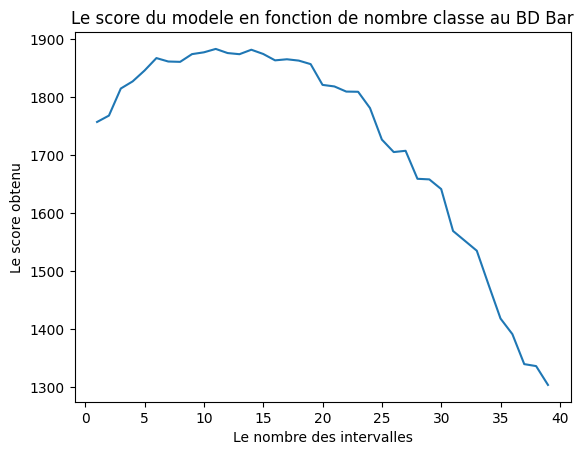

In [45]:
data,classe=load_poi("bar")
#print(len(data))
x,y,best_fit=crois_validation_plot(data)
print(best_fit)
plt.xlabel("Le nombre des intervalles")
plt.ylabel("Le score obtenu")
plt.title("Le score du modele en fonction de nombre classe au BD Bar")
plt.plot(x,y)
plt.show()

5


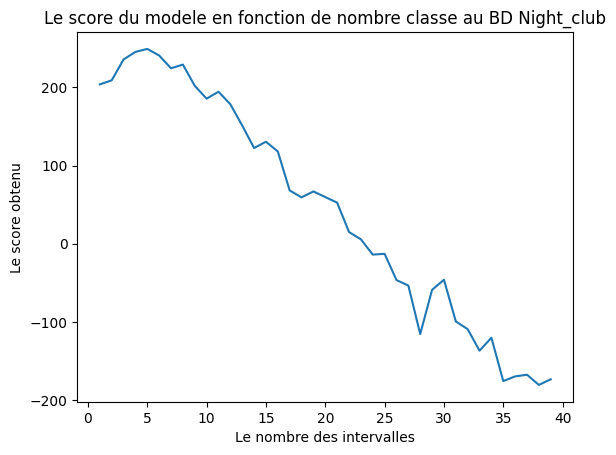

In [46]:
data,classe=load_poi("night_club")
#print(len(data))
x,y,best_fit=crois_validation_plot(data)
print(best_fit)
plt.xlabel("Le nombre des intervalles")
plt.ylabel("Le score obtenu")
plt.title("Le score du modele en fonction de nombre classe au BD Night_club")
plt.plot(x,y)
plt.show()

Comme il y a peu de night_club, alors lorsque le nombre d'intervalles augmente, le score diminue très vite contrairement à bar et restaurant où la densite est plus forte donc le score diminue moins vite lorsque le nombre d'intervalle croit. Donc le meilleur hyper parametre est bien plus bas pour night_club que pour bar et restaurant où c'est du meme ordre.

In [47]:
def kernel_uniform(x):
    #astype pour convertir en entier 0 ou 1
    #axis=-1 si chaque ligne verifie la propriété
    return np.all(np.abs(x) <= 0.5, axis=-1).astype(int)

In [48]:
a=np.array([[0.1,0.2]])
kernel_uniform(a)

array([1])

In [49]:
kernel_uniform(data)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [50]:
def kernel_gaussian(x):
    d = x.shape[-1]
    return np.exp(-0.5 * np.linalg.norm(x, axis=1)**2) * (2*np.pi)**(-d/2) 

In [51]:
def test_kernel(data,kernel,sigma):
    nc_Kernel=KernelDensity(kernel=kernel,sigma=sigma)
    nc_Kernel.fit(data)
    show_density(nc_Kernel, data)
    plt.gca().set_title(f'sigma : {sigma}, score : {nc_Kernel.score(data)}')
    

# Test Kernel Uniform

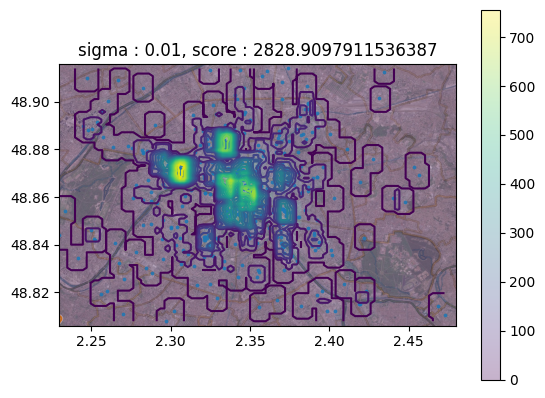

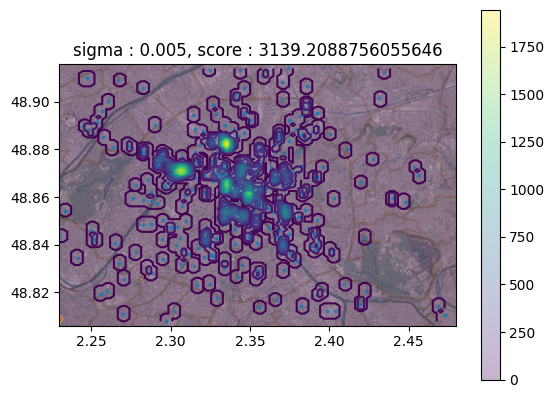

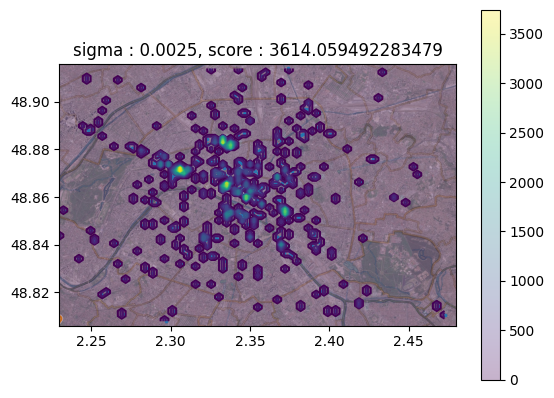

In [52]:
data,classe=load_poi("night_club")
test_kernel(data,kernel_uniform,0.01)
test_kernel(data,kernel_uniform,0.005)
test_kernel(data,kernel_uniform,0.0025)

# Test Kernel Gaussienne

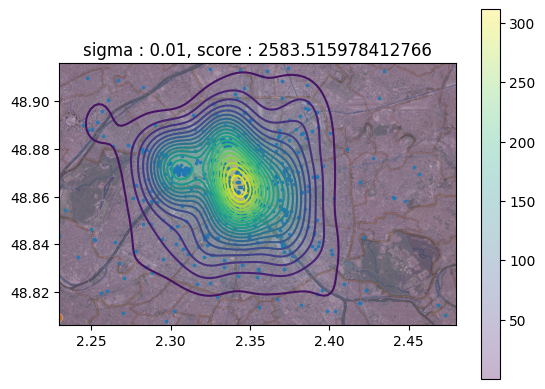

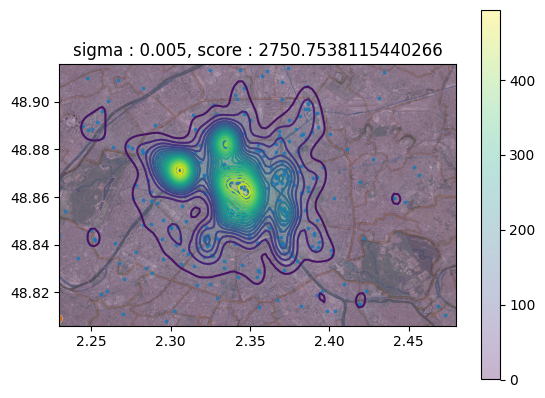

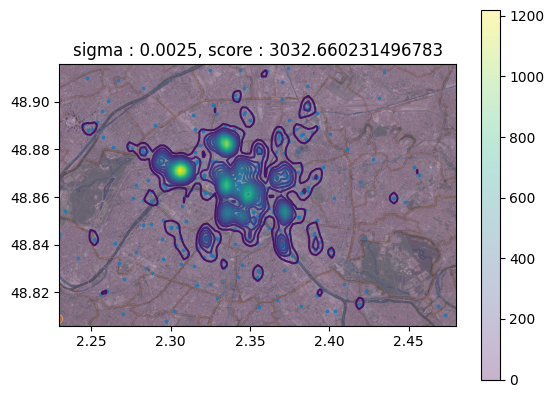

In [53]:
data,classe=load_poi("night_club")
test_kernel(data,kernel_gaussian,0.01)
test_kernel(data,kernel_gaussian,0.005)
test_kernel(data,kernel_gaussian,0.0025)

In [54]:
class Nadaraya(Density):
    def __init__(self, kernel, sigma):
        super().__init__()
        self.kernel = kernel
        self.sigma = sigma
    
    def fit(self, x, y):
        self.x = x
        self.y = y

    def predict(self, data):
        prediction = []
        for x in data:
            noyau = self.kernel((x - self.x) / self.sigma) + 1e-10
            prediction.append(np.sum(self.y * noyau) / np.sum(noyau))
        return np.array(prediction)

In [55]:
def moindre_carre(y,y_pred):
    return  np.sum((y - y_pred) ** 2) / len(y)

In [56]:
from sklearn.model_selection import train_test_split

X, Y = load_poi("bar")
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=.2)

print(X.shape, Y.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4888, 2) (4888,)
(3910, 2) (978, 2) (3910,) (978,)


## Test avec Uniforme

In [57]:
nw = Nadaraya(kernel_uniform,0.01)
nw.fit(X_train, y_train)
y_pred = nw.predict(X_test)
y_pred_nan = np.nan_to_num(y_pred, nan=0)
moindre_carre(y_test, y_pred_nan)

3.708755957439666

## Test avec Gaussienne

In [58]:
nw = Nadaraya(kernel_gaussian,0.01)
nw.fit(X_train, y_train)
y_pred = nw.predict(X_test)
y_pred_nan = np.nan_to_num(y_pred, nan=0)
moindre_carre(y_test, y_pred_nan)

3.6067998072804532

On en déduit que le kernel gaussien est mieux en terme de moindre carrés.Donc on fait le test seulement avec le kernel gaussien.

In [59]:
sigmas = [0.01, 0.1, 1, 10, 100]
mses = []

for sigma in sigmas:
    nw = Nadaraya(kernel_gaussian, sigma)
    nw.fit(X_train, y_train)
    y_pred = nw.predict(X_test)
    y_pred_nan = np.nan_to_num(y_pred, nan=0)
    m = moindre_carre(y_test, y_pred_nan)
    mses.append(m)

mses=np.array(mses)

In [60]:
print("Le sigma optimal est : ")
print(sigmas[np.argmin(mses)])

Le sigma optimal est : 
0.01
